In [1]:
from scripts.VTECDataReader import VTECDataReader
from scripts.subscripts.MiscellanousFunctions import calculate_curvature, find_best_KR_bandwidth, KernelRegression

import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({
    "text.usetex": True
})

In [2]:
PTEX_dir = ["/home/federicoss/Documents/FCFM/Proyecto TIDs/Data/CMN Files/PTEX/2018",
            "/home/federicoss/Documents/FCFM/Proyecto TIDs/Data/CMN Files/PTEX/2019"]

VTECReader = VTECDataReader(PTEX_dir, min_amplitude = 0.0)
VTECReader.read_and_extract_vtec_data()

--Reading Cmn files--
Number of files: 727


100%|██████████| 727/727 [00:23<00:00, 31.44it/s]



--Separate each Cmn file by PRN--


100%|██████████| 727/727 [00:10<00:00, 69.47it/s] 



--Detrend time series by PRN--


100%|██████████| 31/31 [01:33<00:00,  3.03s/it]


In [3]:
min_max_dTEC = {"min":[], "max":[]}

for vtec_series in VTECReader.dtec_sequences:
    min_max_dTEC["min"].append( abs(vtec_series.min()) )
    min_max_dTEC["max"].append( vtec_series.max() )

sorted_min_dTEC_values = np.array(sorted(min_max_dTEC["min"]))
sorted_max_dTEC_values = np.array(sorted(min_max_dTEC["max"]))

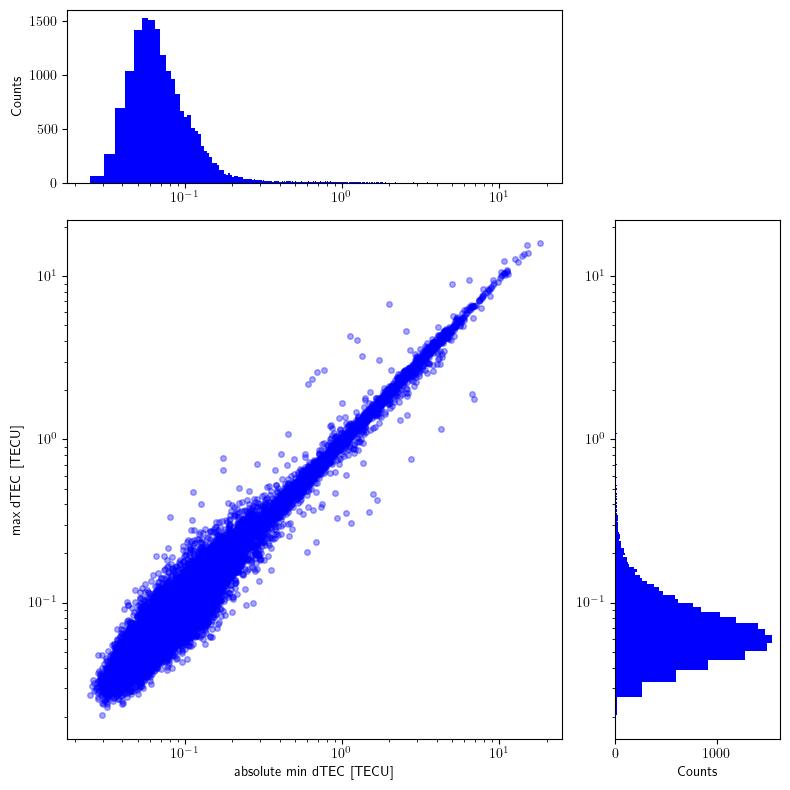

In [4]:
FigureScatter, SubplotsScatter = plt.subplot_mosaic([["HistMin", "."], ["Scatter", "HistMax"]], width_ratios = [3, 1], height_ratios = [1, 3], figsize = (8, 8))

SubplotsScatter["Scatter"].scatter(min_max_dTEC["min"], min_max_dTEC["max"], s = 16, marker = 'o', fc = "blue", alpha = 0.35)
SubplotsScatter["Scatter"].set_xscale("log")
SubplotsScatter["Scatter"].set_yscale("log")
SubplotsScatter["Scatter"].set_xlabel("absolute min dTEC [TECU]")
SubplotsScatter["Scatter"].set_ylabel("max dTEC [TECU]")

SubplotsScatter["HistMin"].hist(min_max_dTEC["min"], bins = "auto", orientation = "vertical", color = "blue")
SubplotsScatter["HistMin"].set_ylabel("Counts")
SubplotsScatter["HistMin"].set_xscale("log")
SubplotsScatter["HistMax"].hist(min_max_dTEC["max"], bins = "auto", orientation = "horizontal", color = "blue")
SubplotsScatter["HistMax"].set_xlabel("Counts")
SubplotsScatter["HistMax"].set_yscale("log")

FigureScatter.tight_layout()

plt.show()

In [5]:
N = sorted_min_dTEC_values.size

sum_indicator_min = np.array([ (n + 1)/N for n in range(N)])
sum_indicator_max = np.array([ (n + 1)/N for n in range(N)])

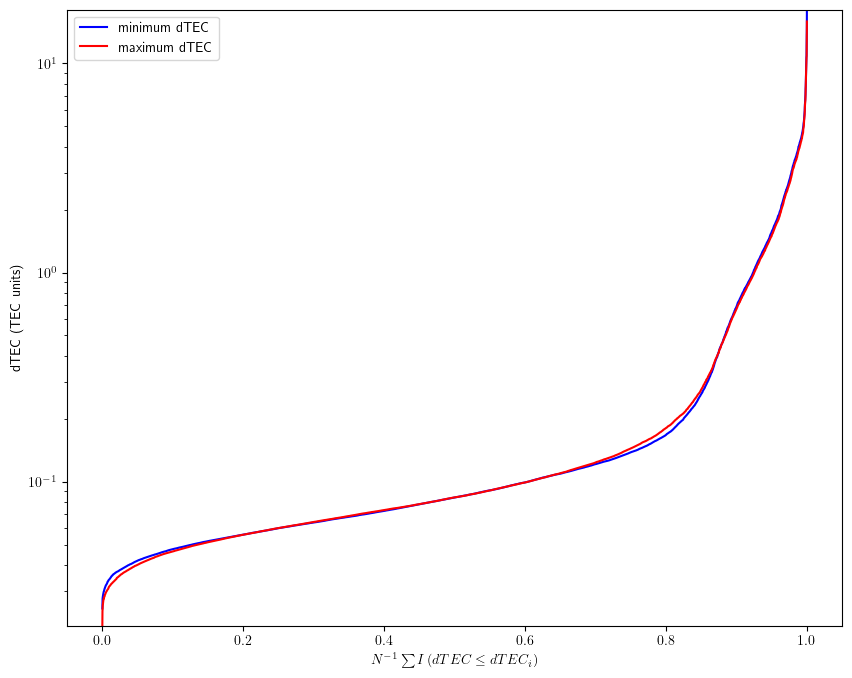

In [6]:
Figure, Subplots = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 8))

y_min, y_max = min(sorted_min_dTEC_values.min(), sorted_max_dTEC_values.min()), max(sorted_min_dTEC_values.max(), sorted_max_dTEC_values.max())

Subplots.plot(sum_indicator_min, sorted_min_dTEC_values, label = "minimum dTEC", color = "blue")
Subplots.plot(sum_indicator_max, sorted_max_dTEC_values, label = "maximum dTEC", color = "red")

Subplots.set_xlabel(r"$N^{-1}\sum I\left(dTEC \leq dTEC_{i}\right)$")
Subplots.set_ylabel("dTEC (TEC units)")
Subplots.set_ylim(y_min, y_max)
Subplots.set_yscale("log")
Subplots.legend()

plt.show()

In [7]:
curvature_min_dTEC = calculate_curvature(sorted_min_dTEC_values, sum_indicator_min)
curvature_max_dTEC = calculate_curvature(sorted_max_dTEC_values, sum_indicator_max)

--Leave-One-Out Cross Validation for Kernel Regression bandwidth--


100%|██████████| 100/100 [03:47<00:00,  2.28s/it]


Optimal bandwidth:  0.009770099572992257
--Leave-One-Out Cross Validation for Kernel Regression bandwidth--


100%|██████████| 100/100 [03:48<00:00,  2.29s/it]

Optimal bandwidth:  0.008497534359086447


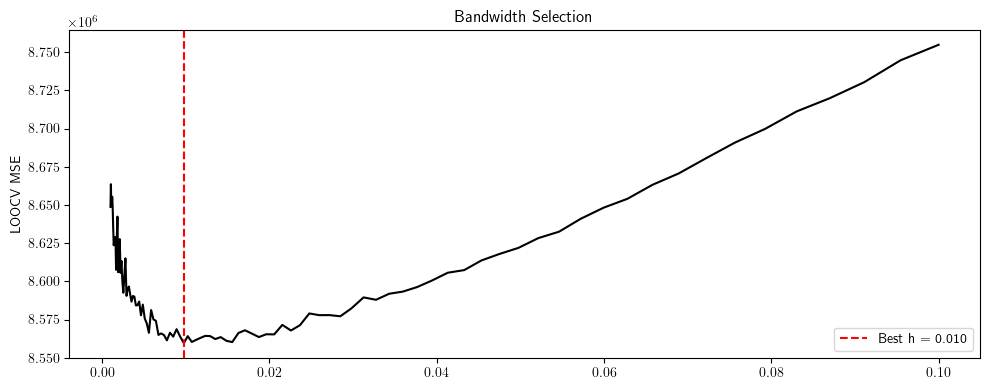

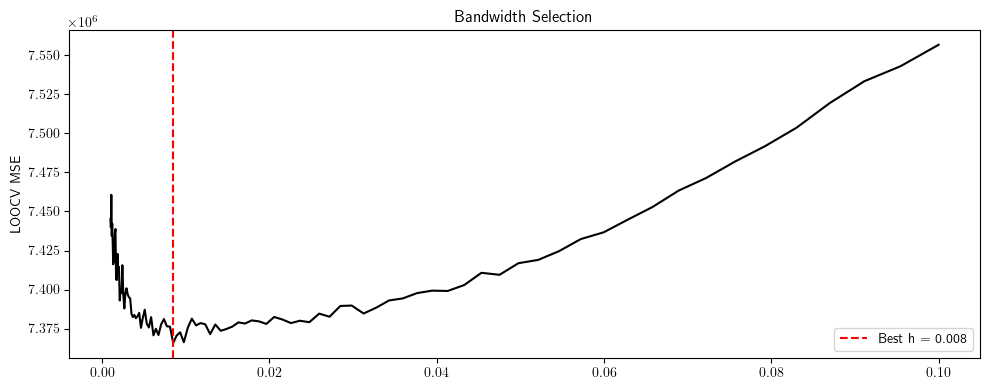

In [8]:
h_values = np.logspace(-3, -1, 100)

best_h_tec_min = find_best_KR_bandwidth(sum_indicator_min, curvature_min_dTEC, h_values = h_values)
best_h_tec_max = find_best_KR_bandwidth(sum_indicator_max, curvature_max_dTEC, h_values = h_values)

In [9]:
fit_smooth_curvature_min = np.array([KernelRegression(sum_indicator_min[n], sum_indicator_min, curvature_min_dTEC, h = best_h_tec_min) for n in range(N)])
fit_smooth_curvature_max = np.array([KernelRegression(sum_indicator_max[n], sum_indicator_max, curvature_max_dTEC, h = best_h_tec_max) for n in range(N)])

min_maxfit_index = np.argmax(fit_smooth_curvature_min)
max_maxfit_index = np.argmax(fit_smooth_curvature_max)

min_xfit = sum_indicator_min[min_maxfit_index]
max_xfit = sum_indicator_max[max_maxfit_index]
min_yfit = fit_smooth_curvature_min[min_maxfit_index]
max_yfit = fit_smooth_curvature_max[max_maxfit_index]

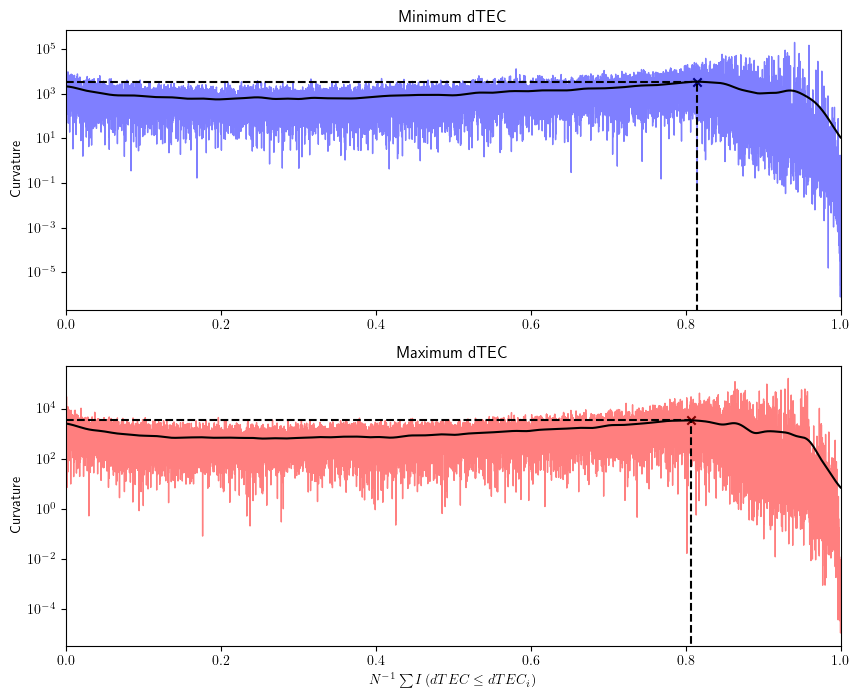

In [10]:
Figure, Subplots = plt.subplots(ncols = 1, nrows = 2, sharex = "row", figsize = (10, 8))

Subplots[0].set_title(label = "Minimum dTEC")
Subplots[0].plot(sum_indicator_min, curvature_min_dTEC, color = "blue", linewidth = 1.0, alpha = 0.5)
Subplots[0].plot(sum_indicator_min, fit_smooth_curvature_min, color = "black")
Subplots[0].plot([0.0, min_xfit], 2*[min_yfit], "--k")
Subplots[0].plot(2*[min_xfit], [0.0, min_yfit], "--k")
Subplots[0].scatter([min_xfit], [min_yfit], marker = "x", c = "black", s = 36)

Subplots[1].set_title(label = "Maximum dTEC")
Subplots[1].plot(sum_indicator_max, curvature_max_dTEC, color = "red", linewidth = 1.0, alpha = 0.5)
Subplots[1].plot(sum_indicator_max, fit_smooth_curvature_max, color = "black")
Subplots[1].plot([0.0, max_xfit], 2*[max_yfit], "--k")
Subplots[1].plot(2*[max_xfit], [0.0, max_yfit], "--k")
Subplots[1].scatter([max_xfit], [max_yfit], marker = "x", c = "black", s = 36)

Subplots[0].set_xlim(0.0, 1.0)
Subplots[0].set_yscale("log")
Subplots[1].set_xlim(0.0, 1.0)
Subplots[1].set_yscale("log")

Subplots[1].set_xlabel(r"$N^{-1}\sum I\left(dTEC \leq dTEC_{i}\right)$")
Subplots[0].set_ylabel("Curvature")
Subplots[1].set_ylabel("Curvature")

plt.show()

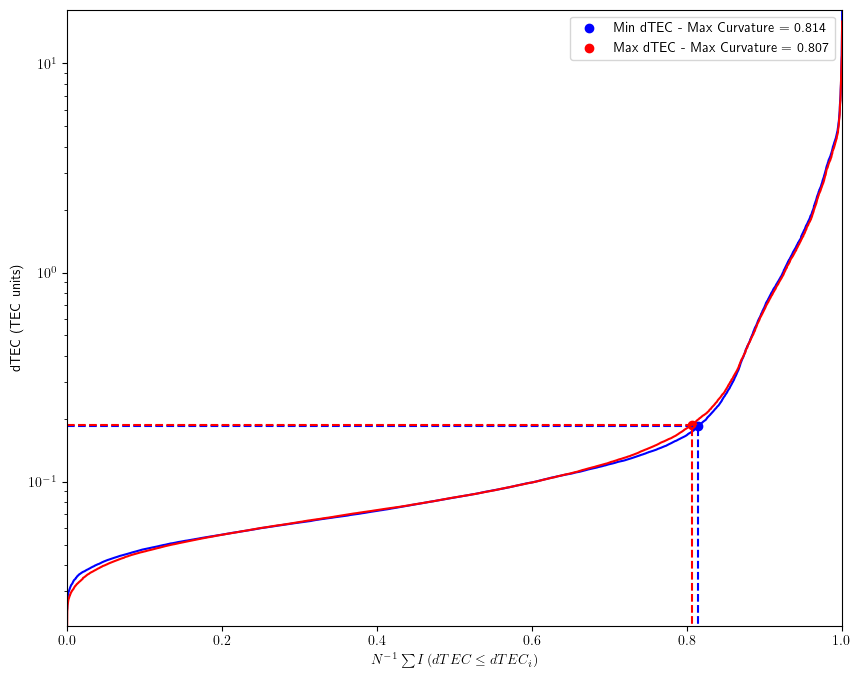

Optimal amplitude threshold for min amplitudes =  0.18370505463567177
Optimal amplitude threshold for max amplitudes =  0.1873192164324049
Mean of optimal amplitude threshold =  0.18551213553403834


In [ ]:
Figure, Subplots = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 8))

y_min, y_max = min(sorted_min_dTEC_values.min(), sorted_max_dTEC_values.min()), max(sorted_min_dTEC_values.max(), sorted_max_dTEC_values.max())
optimal_mindTEC_amp_threshold = sorted_min_dTEC_values[min_maxfit_index]
optimal_maxdTEC_amp_threshold = sorted_max_dTEC_values[max_maxfit_index]

Subplots.plot(sum_indicator_min, sorted_min_dTEC_values, color = "blue")
Subplots.scatter(min_xfit, sorted_min_dTEC_values[min_maxfit_index], label = f"Min dTEC - Max Curvature = {min_xfit:.3f}", color = "blue")
Subplots.plot([0.0, min_xfit], 2*[optimal_mindTEC_amp_threshold], "--b")
Subplots.plot(2*[min_xfit], [0.0, optimal_mindTEC_amp_threshold], "--b")

Subplots.plot(sum_indicator_max, sorted_max_dTEC_values, color = "red")
Subplots.scatter(max_xfit, sorted_max_dTEC_values[max_maxfit_index], label = f"Max dTEC - Max Curvature = {max_xfit:.3f}", color = "red")
Subplots.plot([0.0, max_xfit], 2*[optimal_maxdTEC_amp_threshold], "--r")
Subplots.plot(2*[max_xfit], [0.0, optimal_maxdTEC_amp_threshold], "--r")

Subplots.set_ylim(y_min, y_max)
Subplots.set_xlim(0.0, 1.0)

Subplots.set_xlabel(r"$N^{-1}\sum I\left(dTEC \leq dTEC_{i}\right)$")
Subplots.set_ylabel("dTEC (TEC units)")
Subplots.set_yscale("log")
Subplots.legend()
plt.show()

print("Optimal amplitude threshold for min amplitudes = ", optimal_mindTEC_amp_threshold)
print("Optimal amplitude threshold for max amplitudes = ", optimal_maxdTEC_amp_threshold)
print("Mean of optimal amplitude threshold = ", 0.5*(optimal_mindTEC_amp_threshold + optimal_maxdTEC_amp_threshold))